# Sistema de Recomendación Interactivo con Embeddings de Palabras usando Word2Vec, Plotly, y NetworkX


## Desglose del proyecto
- Análisis Exploratorio de Datos y Preprocesamiento
- Word2Vec con Gensim
- Exploración de resultados
- Construir y visualizar un gráfico de red interactivo

## Análisis Exploratorio de Datos y Preprocesamiento

[Este es el dataset](https://eightportions.com/datasets/Recipes/#fn:1) que vamos a utilizar. Ha sido recopilada por Ryan Lee, y se ha extraído de [Food Network](https://www.foodnetwork.com/), [Epicurious](https://www.epicurious.com/), y [Allrecipes](https://www.allrecipes.com/).

In [1]:
from gensim.parsing.preprocessing import remove_stopwords
from tqdm import tqdm
import pandas as pd
import pickle
import string
import json
import os

In [3]:
os.listdir("./data/Dataset/")

['recipes_raw_nosource_epi.json',
 'LICENSE',
 'recipes_raw_nosource_fn.json',
 'recipes_raw_nosource_ar.json',
 '.ipynb_checkpoints']

In [4]:
recipe_sources = ['ar', 'epi', 'fn']

In [5]:
df = pd.DataFrame()
sources, titles, ingredients, instructions = [], [], [], []
for recipe_source in recipe_sources:
    data = json.load(open(f'data/Dataset/recipes_raw_nosource_{recipe_source}.json', 'r'))
    for _, recipe in data.items():
        if ('title' in recipe) and ('ingredients' in recipe) and ('instructions' in recipe):
            # añadir a una lista de la fuente
            sources.append(recipe_source)
            # añadir a una lista de la titulos
            titles.append(recipe["title"])
            # añadir a una lista de listas de ingredientes , removiendo las palabra ADVERTISEMENT
            ingredients.append([str.replace(ing, "ADVERTISEMENT", "") for ing in recipe["ingredients"]])             
            # añadir a una lista de instrucciones, eliminando la palabra ADVERTISEMENT y remplazando \n por un "".
            instructions.append(str(recipe['instructions']).replace("ADVERTISEMENT", "").replace("\n", ""))
df['source'] = sources
df['title'] = titles
df['ingredients'] = ingredients
df['instructions'] = instructions

In [7]:
df

,source,title,ingredients,instructions
0,ar,Slow Cooker Chicken and Dumplings,"[4 skinless, boneless chicken breast halves , ...","Place the chicken, butter, soup, and onion in ..."
1,ar,Awesome Slow Cooker Pot Roast,[2 (10.75 ounce) cans condensed cream of mushr...,"In a slow cooker, mix cream of mushroom soup, ..."
2,ar,Brown Sugar Meatloaf,"[1/2 cup packed brown sugar , 1/2 cup ketchup ...",Preheat oven to 350 degrees F (175 degrees C)....
3,ar,Best Chocolate Chip Cookies,"[1 cup butter, softened , 1 cup white sugar , ...",Preheat oven to 350 degrees F (175 degrees C)....
4,ar,Homemade Mac and Cheese Casserole,"[8 ounces whole wheat rotini pasta , 3 cups fr...",Preheat oven to 350 degrees F. Line a 2-quart ...
...,...,...,...,...
124642,fn,Summer Corn Salad,"[4 ears fresh corn, 2 heads Belgian endive, 2 ...",Watch how to make this recipe.Preheat a grill....
124643,fn,Zucchini Stuffed Tomatoes,"[4 large plum tomatoes, Salt and sugar, 1 1/2 ...",Preheat the broiler. Cut the tomatoes in 1/2 c...
124644,fn,Pepper Pasta Quick Cook,"[3 tablespoons olive oil, 2 tablespoons unsalt...",Heat the oil and butter in a large skillet ove...
124645,fn,Chocolate Cake with Armagnac Ice Cream,"[8 ounces butter, 8 ounces bittersweet chocola...",Preheat oven to 350 degrees. On the top half o...


In [8]:
to_remove = [
    'tablespoon',
    'tablespoons',
    'teaspoon',
    'teaspoons',
    'tsp',
    'tsps',
    'tbsp',
    'tbsps',
    'pound',
    'pounds',
    'grams',
    'mg',
    'ounce'
    'ounces',
    'kg',
    'crushed',
    'chopped',
    'finely',
    'softened',
    'cups',
    'cup'
]

In [9]:
print(string.punctuation)
print(string.digits)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
0123456789


In [10]:
ord("!"), chr(33)

(33, '!')

In [11]:
translate_table =  str.maketrans("","",string.punctuation+string.digits)
print(translate_table)

{33: None, 34: None, 35: None, 36: None, 37: None, 38: None, 39: None, 40: None, 41: None, 42: None, 43: None, 44: None, 45: None, 46: None, 47: None, 58: None, 59: None, 60: None, 61: None, 62: None, 63: None, 64: None, 91: None, 92: None, 93: None, 94: None, 95: None, 96: None, 123: None, 124: None, 125: None, 126: None, 48: None, 49: None, 50: None, 51: None, 52: None, 53: None, 54: None, 55: None, 56: None, 57: None}


In [12]:
saludo = "Holas!!!! como estan??"
saludo.lower().translate(translate_table)

'holas como estan'

In [13]:
remove_stopwords(saludo)

'Holas!!!! como estan??'

In [14]:
def preprocess(items):
    translate_table =  str.maketrans("","",string.punctuation+string.digits)
    res = []
    for item in items:
        temp = item.lower().replace("-","")
        temp = temp.translate(translate_table)
        temp = remove_stopwords(temp)
        for stop_word in to_remove:
            temp = temp.replace(stop_word,"")
        res.append(temp.split())
        
    return res

In [15]:
print(preprocess (["""Place the chicken, butter, soup, and onion in a slow cooker, 
and fill with enough water to cover.Cover, and cook for 5 to 6 hours on High. 
About 30 minutes before serving, place the torn biscuit dough in the slow cooker. 
Cook until the dough is no longer raw in the center."""]))

[['place', 'chicken', 'butter', 'soup', 'onion', 'slow', 'cooker', 'water', 'covercover', 'cook', 'hours', 'high', 'minutes', 'serving', 'place', 'torn', 'biscuit', 'dough', 'slow', 'cooker', 'cook', 'dough', 'longer', 'raw', 'center']]


In [16]:
instruciones = df.instructions.values
print(instruciones[0])

Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.Cover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.


In [17]:
ingredientes =  [", ".join(x) for  x in df.ingredients.values.tolist()]
ingredientes[0]

'4 skinless, boneless chicken breast halves , 2 tablespoons butter , 2 (10.75 ounce) cans condensed cream of chicken soup , 1 onion, finely diced , 2 (10 ounce) packages refrigerated biscuit dough, torn into pieces , '

In [18]:
train_data = preprocess(instruciones+ingredientes)

In [19]:
print(train_data[0])

['place', 'chicken', 'butter', 'soup', 'onion', 'slow', 'cooker', 'water', 'covercover', 'cook', 'hours', 'high', 'minutes', 'serving', 'place', 'torn', 'biscuit', 'dough', 'slow', 'cooker', 'cook', 'dough', 'longer', 'raw', 'center', 'skinless', 'boneless', 'chicken', 'breast', 'halves', 's', 'butter', 'ounce', 'cans', 'condensed', 'cream', 'chicken', 'soup', 'onion', 'diced', 'ounce', 'packages', 'refrigerated', 'biscuit', 'dough', 'torn', 'pieces']


In [20]:
len(train_data)

124647

In [21]:
# guardamos los datos en un archivo pickle de python
with open("train_data.pkl", "wb") as file:
    pickle.dump(train_data, file)

# Tarea 3: Word2Vec con Gensim
Los documentos originales de Word2Vec pueden encontrarse [aquí](https://arxiv.org/pdf/1301.3781.pdf) y [aquí](https://arxiv.org/pdf/1310.4546.pdf), mientras que la documentación del modelo Gensim puede encontrarse [aquí](https://radimrehurek.com/gensim/models/word2vec.html).

![Word2Vec architecture](data/word2vec.jpeg)

In [22]:
from gensim.models.word2vec import Word2Vec

In [23]:
with open("train_data.pkl","rb") as file:
    train_set = pickle.load(file)

In [24]:
print(*train_set[:5],sep="\n\n")

['place', 'chicken', 'butter', 'soup', 'onion', 'slow', 'cooker', 'water', 'covercover', 'cook', 'hours', 'high', 'minutes', 'serving', 'place', 'torn', 'biscuit', 'dough', 'slow', 'cooker', 'cook', 'dough', 'longer', 'raw', 'center', 'skinless', 'boneless', 'chicken', 'breast', 'halves', 's', 'butter', 'ounce', 'cans', 'condensed', 'cream', 'chicken', 'soup', 'onion', 'diced', 'ounce', 'packages', 'refrigerated', 'biscuit', 'dough', 'torn', 'pieces']

['slow', 'cooker', 'mix', 'cream', 'mushroom', 'soup', 'dry', 'onion', 'soup', 'mix', 'water', 'place', 'pot', 'roast', 'slow', 'cooker', 'coat', 'soup', 'mixturecook', 'high', 'setting', 'hours', 'low', 'setting', 'hours', 'ounce', 'cans', 'condensed', 'cream', 'mushroom', 'soup', 'ounce', 'package', 'dry', 'onion', 'soup', 'mix', 'water', 's', 'pot', 'roast']

['preheat', 'oven', 'degrees', 'f', 'degrees', 'c', 'lightly', 'grease', 'x', 'inch', 'loaf', 'panpress', 'brown', 'sugar', 'prepared', 'loaf', 'pan', 'spread', 'ketchup', 'sugar

In [25]:
model = Word2Vec()

In [27]:
model?

Type:            Word2Vec
String form:     Word2Vec<vocab=0, vector_size=100, alpha=0.025>
File:            ~/.local/lib/python3.6/site-packages/gensim/models/word2vec.py
Docstring:       <no docstring>
Class docstring:
Serialize/deserialize objects from disk, by equipping them with the `save()` / `load()` methods.

Warnings
--------
This uses pickle internally (among other techniques), so objects must not contain unpicklable attributes
such as lambda functions etc.
Init docstring: 
Train, use and evaluate neural networks described in https://code.google.com/p/word2vec/.

Once you're finished training a model (=no more updates, only querying)
store and use only the :class:`~gensim.models.keyedvectors.KeyedVectors` instance in ``self.wv``
to reduce memory.

The full model can be stored/loaded via its :meth:`~gensim.models.word2vec.Word2Vec.save` and
:meth:`~gensim.models.word2vec.Word2Vec.load` methods.

The trained word vectors can also be stored/loaded from a format compatible with th

In [28]:
model.build_vocab(train_set)

In [34]:
model.corpus_count

124647

In [35]:
model.epochs

5

In [36]:
%%time
model.train(train_data,total_examples=model.corpus_count,epochs=5)

CPU times: user 2min 1s, sys: 425 ms, total: 2min 2s
Wall time: 42.3 s


(66521429, 79318715)

In [45]:
model.wv.most_similar(["ketchup"],topn=20)

[('heinz', 0.6571635007858276),
 ('mayo', 0.6153947710990906),
 ('worcestershire', 0.6105203032493591),
 ('spicy', 0.6074661612510681),
 ('catsup', 0.6045454740524292),
 ('molasses', 0.5750892162322998),
 ('relish', 0.556661069393158),
 ('barbeque', 0.5455542206764221),
 ('mayonnaise', 0.5450972318649292),
 ('sriracha', 0.5367729663848877),
 ('mustards', 0.5127382874488831),
 ('heinz®', 0.5127269625663757),
 ('hoisin', 0.5106196999549866),
 ('sambal', 0.5096207857131958),
 ('bbq', 0.49981871247291565),
 ('robust', 0.4988099932670593),
 ('horseradish', 0.4963374733924866),
 ('mustard', 0.48951753973960876),
 ('stonewall', 0.482272207736969),
 ('gochujang', 0.4788217842578888)]

In [51]:
model.wv.most_similar(["ketchup","meat"],topn=20)

[('beef', 0.6453953981399536),
 ('pork', 0.6091479063034058),
 ('brisket', 0.6036219000816345),
 ('bbq', 0.5216721296310425),
 ('spicy', 0.5125448107719421),
 ('heinz', 0.5096468925476074),
 ('meatloaf', 0.5089074373245239),
 ('barbeque', 0.49073556065559387),
 ('worcestershire', 0.4840894639492035),
 ('mayo', 0.47967591881752014),
 ('turkey', 0.4788751006126404),
 ('ham', 0.47494128346443176),
 ('lamb', 0.47399842739105225),
 ('chuck', 0.47399330139160156),
 ('ribs', 0.4667322039604187),
 ('sauerkraut', 0.4607003629207611),
 ('meats', 0.45439714193344116),
 ('marrow', 0.44660863280296326),
 ('venison', 0.44464167952537537),
 ('hickoryflavored', 0.4377784729003906)]

In [58]:
model.wv.get_vector("meat")

array([-1.6082883 , -0.32198814, -1.4903114 , -2.6145904 ,  2.1973662 ,
       -1.974392  ,  1.0898836 , -3.214962  ,  0.8179817 , -0.06846127,
       -1.7316581 ,  1.186098  ,  1.1929792 , -0.5312073 , -0.58502454,
       -0.27867654, -0.1699327 , -3.4296887 , -3.618814  , -0.08435823,
       -0.25353122,  1.2148504 , -0.4401999 ,  0.6332404 ,  1.6106609 ,
       -2.853538  , -1.8416764 , -1.7810328 ,  0.2711277 , -2.939592  ,
        0.1650781 ,  1.1206805 , -3.8843188 ,  0.63244313,  1.3187354 ,
       -0.8277443 , -2.0555584 ,  0.92414385, -0.3857094 , -0.39379764,
       -1.0206289 , -0.82750016,  2.8942797 ,  2.0596714 ,  2.178054  ,
        2.2262933 , -1.0033662 , -0.3845928 , -1.8265071 ,  0.10073816,
       -2.5294874 ,  2.7709231 , -0.6575268 ,  2.1890512 ,  1.0141577 ,
       -2.5145452 ,  1.2480996 ,  1.4671733 , -3.9060495 ,  0.78097314,
        2.4074018 , -3.289538  ,  1.582524  , -0.40088516,  3.9284587 ,
        0.0461649 , -2.8463302 , -3.8645449 , -0.3671131 , -1.01

In [52]:
# guardamos el modelo
model.save("m2v.model")

# Exploración de resultados

In [182]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
matplotlib.rcParams['figure.dpi'] = 800
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import random
random.seed(3)

In [183]:
# cargamos el modelo ya entrenado
modelo = Word2Vec.load("m2v.model")

In [184]:
modelo

In [185]:
modelo.wv.most_similar("orange",topn=3)

[('tangerine', 0.8884228467941284),
 ('lemon', 0.8257062435150146),
 ('clementine', 0.7734940648078918)]

In [186]:
# leemos el archivo de item for sales
with open("./data/items_for_sale.txt","r",encoding="utf-8") as f:
    items_for_sale = f.read().split("\n")

In [187]:
len(items_for_sale), type(items_for_sale)

(911, list)

In [188]:
items_for_sale[:5]

['salt', 'pepper', 'fresh', 'oil', 'sugar']

In [189]:
word, vector= [],[]
for item in items_for_sale:
    try:
        vector.append(modelo.wv.get_vector(item))
        word.append(item)
    except :
        print(f"{item} no se escuentra en el vocabulario")
        

antibiotic no se escuentra en el vocabulario
parmigianino no se escuentra en el vocabulario


In [190]:
len(word),len(vector)

(909, 909)

In [191]:
word[0],vector[0]

('salt',
 array([-0.3108869 , -1.9639693 , -1.8049109 , -1.5184522 ,  0.31983635,
         2.9197145 ,  0.44674444,  2.1959178 , -3.0735898 ,  0.36727494,
        -2.081145  , -1.2397251 ,  5.8311152 , -3.147677  , -4.0886054 ,
         1.4718609 , -0.43496478,  2.518629  , -0.02874204,  2.4409313 ,
        -4.768551  , -1.6094497 ,  0.44332668, -0.74148047,  1.2397006 ,
         0.7385827 ,  2.1841395 ,  1.2674823 , -1.411634  , -0.02812971,
        -0.05302836,  1.1326407 , -0.44252366,  0.32075182,  2.020857  ,
         3.104058  , -0.56417733,  0.14883088,  2.8658926 ,  5.5775385 ,
        -3.2251313 ,  2.5770597 , -3.8279889 , -0.64242136, -0.3723239 ,
         3.91199   ,  0.5642394 , -0.72569823, -1.7812047 , -0.14880131,
        -2.8882256 , -1.1456863 , -0.8375254 , -1.668331  , -4.2215333 ,
         2.104696  ,  2.0209236 ,  0.8865608 ,  0.02900942, -1.064961  ,
         0.1418429 , -0.89285123, -0.06014572, -1.5805461 ,  0.13644254,
         1.8289425 ,  1.8331763 ,  0.73151

In [192]:
# generamos una matriz cuadrada con la similitud entre vectores
similitud = cosine_similarity(vector, vector)

In [193]:
similitud.shape

(909, 909)

In [194]:
# la diagonal de la matriz tiene un valor de 1 ya que la similitud entre dos vectores iguales es de 1

In [195]:
false_matrix = ~np.isclose(np.diagonal(similitud),np.identity(909))

In [196]:
similitud = similitud * false_matrix

In [197]:
print(similitud)

[[ 0.          0.30490172  0.13923064 ... -0.13524482 -0.04921711
  -0.1539414 ]
 [ 0.30490172  0.          0.16326454 ... -0.19556847 -0.1293572
  -0.24491316]
 [ 0.13923064  0.16326454  0.         ...  0.33233276  0.1614914
   0.21450181]
 ...
 [-0.13524479 -0.1955685   0.33233273 ...  0.          0.26597506
   0.37225708]
 [-0.04921709 -0.12935719  0.16149147 ...  0.26597506  0.
   0.37411463]
 [-0.1539414  -0.24491316  0.21450181 ...  0.37225708  0.37411463
   0.        ]]


In [198]:
indices = list(range(len(word)))

In [199]:
random.shuffle(indices)

In [200]:
ind = indices[:15]

In [201]:
ind

[694, 342, 628, 259, 176, 819, 16, 762, 287, 390, 74, 742, 124, 328, 569]

In [202]:
small_word   = [word[x] for x in ind ]
small_vector = [vector[x] for x in ind]

In [203]:
small_sims = cosine_similarity(small_vector,small_vector)

In [204]:
for i in range(len(small_sim)):
    small_sims[i,i] = 0
small_sims

array([[ 0.        , -0.02426834,  0.36990687,  0.3537075 ,  0.0889322 ,
         0.0707402 , -0.01843328,  0.30719468,  0.1231297 ,  0.16269235,
         0.00755123,  0.16227064,  0.20459087,  0.04306662,  0.14402579],
       [-0.02426834,  0.        ,  0.16789776,  0.01705533,  0.1327549 ,
         0.28203237, -0.0550996 , -0.07616839, -0.04871391, -0.19127274,
        -0.12442202, -0.00168111,  0.0362017 , -0.1116769 , -0.21178721],
       [ 0.36990687,  0.16789776,  0.        ,  0.21991962, -0.09630873,
         0.32394361,  0.05502696,  0.26871303,  0.01981971,  0.04045086,
         0.06174996,  0.13202311,  0.01199681,  0.07695149,  0.12455936],
       [ 0.3537075 ,  0.01705533,  0.21991962,  0.        ,  0.0724603 ,
         0.01137337,  0.04376272,  0.18246065,  0.28805014,  0.49323887,
        -0.0797607 ,  0.54520935, -0.1332984 ,  0.14687608, -0.09174385],
       [ 0.0889322 ,  0.1327549 , -0.09630873,  0.0724603 ,  0.        ,
        -0.14804041,  0.12159428,  0.21595486, 

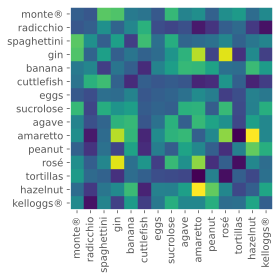

In [205]:
fig, ax = plt.subplots()
im = ax.imshow(small_sims)
ax.set_xticks(np.arange(len(small_vector)))
ax.set_yticks(np.arange(len(small_vector)))

ax.set_xticklabels(small_word)
ax.set_yticklabels(small_word)
ax.grid(False)

plt.setp(ax.get_xticklabels(), rotation=90)

fig.tight_layout()
plt.show()

In [207]:
np.savetxt("word.txt",word,fmt="%s")

In [208]:
np.save("vectors.npy",vector)

# Construcción y visualización de gráficos de red interactivos

In [209]:
import plotly.graph_objects as go
from plotly.offline import plot
import networkx as nx

In [210]:
words =  np.loadtxt("word.txt", dtype=str)

In [211]:
print(words)

['salt' 'pepper' 'fresh' 'oil' 'sugar' 'butter' 'garlic' 'cheese' 'water'
 'lemon' 'leaves' 'cloves' 'powder' 'chicken' 'milk' 'unsalted' 'eggs'
 'vanilla' 'egg' 'vinegar' 'vegetable' 'baking' 'extract' 'wine'
 'tomatoes' 'parsley' 'brown' 'virgin' 'cinnamon' 'chocolate' 'orange'
 'lime' 'bread' 'mustard' 'seeds' 'bell' 'rice' 'ginger' 'thyme'
 'cilantro' 'broth' 'potatoes' 'beef' 'celery' 'tomato' 'beans' 'parmesan'
 'honey' 'soda' 'zest' 'clove' 'stock' 'sour' 'leaf' 'mushrooms' 'carrots'
 'syrup' 'cayenne' 'bacon' 'pork' 'coconut' 'oregano' 'mayonnaise' 'chili'
 'chile' 'cheddar' 'seasoning' 'nutmeg' 'canola' 'chips' 'mint' 'rosemary'
 'scallions' 'chives' 'peanut' 'breast' 'cornstarch' 'almonds' 'cider'
 'shrimp' 'shallots' 'worcestershire' 'yogurt' 'walnuts' 'spinach' 'cocoa'
 'olives' 'jalapeno' 'pineapple' 'buttermilk' 'balsamic' 'lettuce' 'pasta'
 'turkey' 'cake' 'mozzarella' 'fillets' 'chunks' 'peas' 'chiles'
 'semisweet' 'sausage' 'carrot' 'coriander' 'raisins' 'pecans' 'cher

In [213]:
vectores = np.load("vectors.npy")

In [214]:
len(vectores)

909

In [243]:
similitudes = cosine_similarity(vectores,vectores)

In [244]:
for i in range(len(vectores)):
    for j in range(len(vectores)):
        if i<=j:
            similitudes[i,j]=False

In [256]:
indices = np.argwhere(similitudes > 0.65)

In [258]:
print(len(indices))
indices

1208


array([[ 18,  16],
       [ 30,   9],
       [ 31,   9],
       ...,
       [900, 318],
       [900, 562],
       [908, 875]])

In [273]:
G = nx.Graph()

In [274]:
for indice in indices:
    G.add_edge(word[indice[0]],word[indice[1]], weight=similitud[indice[0],indice[1]])

In [275]:
weight_values = nx.get_edge_attributes(g,"weight")

In [276]:
print(len(weight_values))
weight_values 

1208


{('egg', 'eggs'): 0.7793944,
 ('orange', 'lemon'): 0.82570636,
 ('orange', 'lime'): 0.7146077,
 ('orange', 'oranges'): 0.66387576,
 ('orange', 'grapefruit'): 0.71603984,
 ('orange', 'tangerine'): 0.88842297,
 ('orange', 'clementine'): 0.77349406,
 ('lemon', 'lime'): 0.81879765,
 ('lemon', 'lemons'): 0.73653644,
 ('lemon', 'limes'): 0.70486593,
 ('lemon', 'tangerine'): 0.7871355,
 ('lime', 'limes'): 0.87218493,
 ('lime', 'tangerine'): 0.6760551,
 ('tomato', 'tomatoes'): 0.6892227,
 ('clove', 'cloves'): 0.9259622,
 ('stock', 'broth'): 0.9437542,
 ('leaf', 'leaves'): 0.82919884,
 ('pork', 'beef'): 0.7218988,
 ('pork', 'lamb'): 0.79104364,
 ('pork', 'veal'): 0.7077803,
 ('pork', 'venison'): 0.79339707,
 ('beef', 'veal'): 0.66650164,
 ('beef', 'venison'): 0.68542624,
 ('beef', 'bison'): 0.66466534,
 ('oregano', 'thyme'): 0.7302985,
 ('oregano', 'rosemary'): 0.6967344,
 ('oregano', 'marjoram'): 0.8051204,
 ('thyme', 'rosemary'): 0.91226447,
 ('thyme', 'tarragon'): 0.7735898,
 ('thyme', 'marj

In [277]:
nx.spring_layout?

Signature:
nx.spring_layout(
    G,
    k=None,
    pos=None,
    fixed=None,
    iterations=50,
    threshold=0.0001,
    weight='weight',
    scale=1,
    center=None,
    dim=2,
    seed=None,
)
Docstring:
Position nodes using Fruchterman-Reingold force-directed algorithm.

The algorithm simulates a force-directed representation of the network
treating edges as springs holding nodes close, while treating nodes
as repelling objects, sometimes called an anti-gravity force.
Simulation continues until the positions are close to an equilibrium.

There are some hard-coded values: minimal distance between
nodes (0.01) and "temperature" of 0.1 to ensure nodes don't fly away.
During the simulation, `k` helps determine the distance between nodes,
though `scale` and `center` determine the size and place after
rescaling occurs at the end of the simulation.

Fixing some nodes doesn't allow them to move in the simulation.
It also turns off the rescaling feature at the simulation's end.
In additio

In [279]:
posiciones = nx.spring_layout(G)

In [280]:
posiciones

{'egg': array([-0.55889744, -0.91170067]),
 'eggs': array([-0.53823972, -0.87604785]),
 'orange': array([ 0.01749714, -0.28436524]),
 'lemon': array([ 0.01936204, -0.31066048]),
 'lime': array([ 0.01186727, -0.31502551]),
 'tomato': array([-0.56671804, -0.69667095]),
 'tomatoes': array([-0.53790653, -0.66632468]),
 'clove': array([ 0.80234802, -0.72799993]),
 'cloves': array([ 0.82941437, -0.75193518]),
 'stock': array([-0.55772316,  0.85638291]),
 'broth': array([-0.54468232,  0.85074443]),
 'leaf': array([-0.2875621 ,  0.78366715]),
 'leaves': array([-0.29347405,  0.79935497]),
 'pork': array([0.15928584, 0.2285341 ]),
 'beef': array([0.16098465, 0.24210893]),
 'oregano': array([-0.63163173,  0.42548221]),
 'thyme': array([-0.60745108,  0.41806397]),
 'chile': array([-0.20764031,  0.29492193]),
 'chili': array([-0.1938141 ,  0.34169316]),
 'canola': array([-0.81933737,  0.24145639]),
 'vegetable': array([-0.78060871,  0.22560962]),
 'mint': array([-0.67419285, -0.73599941]),
 'cilant

In [282]:
nx.set_node_attributes(G,values=posiciones, name="position")

In [284]:
edge_x = []
edge_y = []
weights = []
ave_x, ave_y = [], []
searches = []
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['position']
    x1, y1 = G.nodes[edge[1]]['position']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)
    ave_x.append(np.mean([x0, x1]))
    ave_y.append(np.mean([y0, y1]))
    weights.append(f'{edge[0]}, {edge[1]}: {weight_values[(edge[0], edge[1])]}')

edge_trace = go.Scatter(
                        x         = edge_x, 
                        y         = edge_y,
                        opacity   = 0.7,
                        line      = dict(width=2, color='White'),
                        hoverinfo = 'text',
                        mode      = 'lines'
                        )

edge_trace.text = weights


node_x = []
node_y = []
sizes = []
for node in G.nodes():
    x, y = G.nodes[node]['position']
    node_x.append(x)
    node_y.append(y)
    if node in searches:
        sizes.append(50)
    else:
        sizes.append(15)

node_trace = go.Scatter(
                        x         = node_x,  
                        y         = node_y,
                        mode      = 'markers',
                        hoverinfo = 'text',
                        marker    = dict(
                                    showscale = True,
                                    line      = dict(color = 'White'),
                                    # colorscale options
                                    # Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
                                    #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
                                    #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
                                    colorscale   = 'Picnic',
                                    reversescale = False,
                                    color        = [],
                                    opacity      = 0.9,
                                    size         = sizes,
                                    colorbar     = dict(
                                            thickness = 15,
                                            title     = 'Node Connections',
                                            xanchor   = 'left',
                                            titleside = 'right'
                                                        ),
                                    line_width   = 2
                                            )
                        )

invisible_similarity_trace = go.Scatter(
                                        x         = ave_x, 
                                        y         = ave_y,
                                        mode      = 'markers',
                                        hoverinfo = 'text',
                                        marker    = dict(
                                                        color   = [],
                                                        opacity = 0,
                                                        )
                                        )

invisible_similarity_trace.text = weights

In [285]:
node_adjacencies = []
node_text        = []
for node, adjacencies in enumerate(G.adjacency()):
    node_adjacencies.append(len(adjacencies[1]))
    node_text.append(adjacencies[0])

node_trace.marker.color = node_adjacencies
node_trace.text         = node_text

In [286]:
fig = go.Figure(
                data   = [edge_trace, node_trace, invisible_similarity_trace],
                layout = go.Layout(
                                    title          = 'Network Graph of Word Embeddings',
                                    template       = 'plotly_dark',
                                    titlefont_size = 20,
                                    showlegend     = False,
                                    hovermode      = 'closest',
                                    margin         = dict(
                                                        b = 20,
                                                        l = 5,
                                                        r = 5,
                                                        t = 40
                                                         ),
                                    annotations   = [
                dict(
                text      =  "Adapted from: <a href='https://plotly.com/ipython-notebooks/network-graphs/'> https://plotly.com/ipython-notebooks/network-graphs/</a>",
                showarrow = False,
                xref      = "paper", 
                yref      = "paper",
                x         = 0.005, 
                y         = -0.002 
                    ) 
                                                    ],
                                    xaxis = dict(showgrid        = False, 
                                                 zeroline        = False, 
                                                 showticklabels  = False
                                                ),
                                    yaxis = dict( showgrid       = False, 
                                                  zeroline       = False, 
                                                  showticklabels = False
                                                )
                                   )
                )

plot(fig)

'temp-plot.html'